In [1]:
using Plots
using Distributions
using StatsBase

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1278


In [2]:
# Releant parameters

d_seed = 40;         # seed particle size [nm]
d_final = 110;       # final selected size [nm]
err = 0.03;          # fractional uncertainty in diameter


In [3]:
# Goal: create a distribution of potential values for OVF based on uncertainties
# in either the initial or final seed sizes. Allow sigma = d_p * err

# final location for OVF
OVF = zeros(10^5)

# calcualting a bunch of OVF options
for i = 1:10^5
    d_s = rand(Normal(d_seed,d_seed*err));
    d_f = rand(Normal(d_final,d_final*err));
    OVF[i] = (d_f^3 - d_s^3)/d_f^3;
end

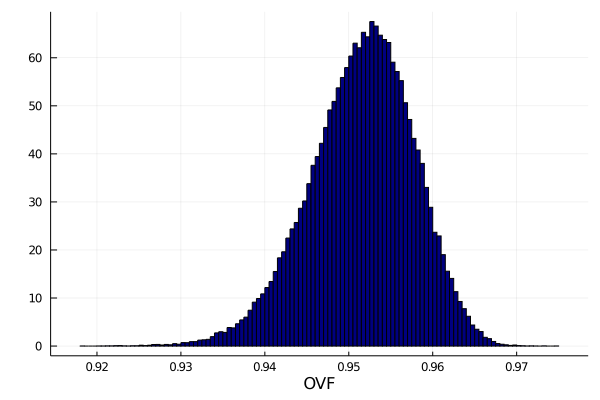

In [4]:
# plotting

histogram(OVF, #xlims = (0.4,0.85),
    color = "navy",
    legend = :none,
    label = "OVF",
    legendfontsize = 10,
    ylabel = " ",
    xlabel = "OVF",
    norm = :true)

In [5]:
# Fit the data
norm_dist = fit(Normal, OVF);

In [6]:
# Creating a fitted pdf

# use this function for some sigma and mu across some sample grid A to plot
function prob_dist(sig_i,A_i,mu)
    p = (1/(sig_i*(2*pi)^(1/2)))*exp(-0.5*((A_i-mu)/(sig_i))^2)
    return p
end

sample_grid = collect(0:0.001:1);
prob = zeros(length(sample_grid));

# Looping through possiblities
for i=1:length(sample_grid)
    prob[i] = prob_dist(norm_dist.σ,norm_dist.μ,sample_grid[i]);
end

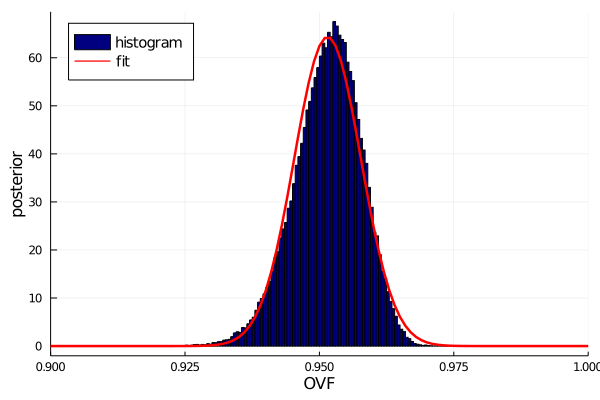

In [7]:
histogram(OVF, xlims = (0.90,1),
    color = "navy",
    legend = :topleft,
    label = "histogram",
    legendfontsize = 10,
    xlabel = "OVF",
    ylabel = "posterior",
    norm = :true)
plot!(sample_grid, prob,
    linewidth = 2.5,
    color = "red",
    label = "fit")

In [8]:
# recording final mu's based on error
err = [0.01 0.02 0.03 0.05 0.1];
mu = [0.6567383695324378,
    0.6558779423807243,
    0.6541646386543627,
    0.6489974422867302,
    0.6359717033055828,
    0.6241930768633636];

# true OVF
ovf_true = (d_final^3 - d_seed^3) / d_final^3

0.9519158527422991

In [9]:
# check fractional uncertainty
norm_dist.σ/norm_dist.μ

0.0065174910486430265

## Analytical solution for variance

We can write our oganic volume fraction as a function of two variables, the seed size and the final size:

$$ OVF = \frac{d_f^3 - d_s^3}{d_f^3} $$

If we apply the simplified formula for error propogation from Wikipedia page on error propogation

$$ s_f = \sqrt{ \left(\frac{\partial f}{\partial x}\right)^2 s_x^2 + \left(\frac{\partial f}{\partial y} \right)^2 s_y^2 + \left(\frac{\partial f}{\partial z} \right)^2 s_z^2 + \cdots} $$

We can calculate the partial derivatives from our function

$$ \frac{\partial(OVF)}{\partial(d_s)} = -3 \frac{d_s^2}{d_f^3} \qquad \frac{\partial(OVF)}{\partial(d_f)} = 3 \frac{d_s^3}{d_f^4} $$

And combining into the total standard deviatino equation

$$ \sigma_{OVF} = \sqrt{ \sigma_{d_s}^2 \left( -3 \frac{d_s^2}{d_f^3} \right)^2 + \sigma_{d_f}^2 \left( 3 \frac{d_s^3}{d_f^4} \right)^2 } $$

In [10]:
# solving the error given by the final equation above
# assuming the standard deviation is just the diameter * error

σ_OVF = ((d_seed * err)^2 * (-3 * d_seed^2/d_final^3)^2 + (d_final * err)^2 * (3 * d_seed^3/d_final^4)^2)^0.5


LoadError: DimensionMismatch("A has dimensions (1,5) but B has dimensions (1,5)")

In [11]:
# what is the standard deviation asa fraction of true OVF 

frac_err = σ_OVF/ovf_true

LoadError: UndefVarError: σ_OVF not defined

In [12]:
# Function to calculate error accoring to above equation

function calc_error(d_seedz, d_finalz, errz)
    σ_OVFz = ((d_seedz * errz)^2 * (-3 * d_seedz^2/d_finalz^3)^2 + (d_finalz * errz)^2 * (3 * d_seedz^3/d_finalz^4)^2)^0.5
    return σ_OVFz
end


calc_error (generic function with 1 method)

In [13]:
# Let's test across a range of inlet and outlet sizes

d_f = collect(70:0.1:130)
d_s = collect(30:0.1:60)
err = 0.03
final_err = zeros(length(d_s), length(d_f))

for i = 1:length(d_s)
    for j = 1:length(d_f)
        final_err[i,j] = calc_error(d_s[i],d_f[j], err)
    end
end

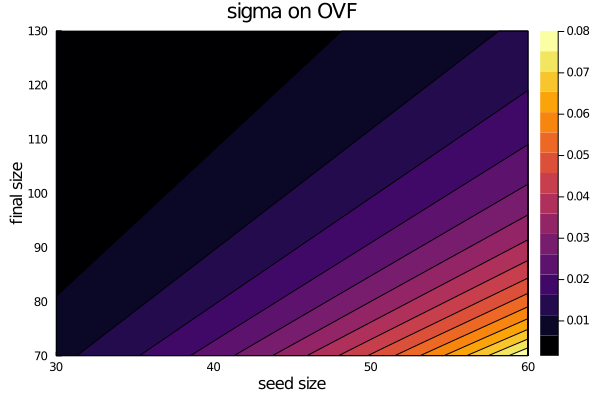

In [14]:
# Plotting

contourf(d_s, d_f, final_err', 
    xlabel = "seed size", 
    ylabel = "final size",
    title = "sigma on OVF")